# Natural Language Processing Assignment Source Code

In [63]:
import math
from typing import Literal

from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.svm import SVC
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
import os
import tqdm.auto as tqdm
from os import path
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.functional import F
from bert_sklearn import load_model, BertClassifier
import simpletransformers
from torch.utils.data import Dataset
from transformers import pipeline, BertTokenizer, BertModel
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import unicodedata
import time
import joblib

In [21]:
device = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}.")

AttributeError: module 'tqdm.notebook' has no attribute 'pandas'

Load Data

In [3]:
DATA_PATH = "./fnc-1/"


def load_dataframe_raw(
    set_type: Literal["train", "test", "competition_test"],
    table_name: Literal["stances", "bodies"],
    unlabelled: bool = False,
    random: bool = False
) -> pd.DataFrame:
    return pd.read_csv(path.join(
        DATA_PATH,
        f"{set_type}_{table_name}" +
        ("_unlabeled" if unlabelled else "") +
        (".random" if random else "") +
        ".csv"
    ), index_col="Body ID" if table_name == "bodies" else None)


In [4]:
sp = spacy.load("en_core_web_sm")
stop_words = sp.Defaults.stop_words

train_stances = load_dataframe_raw("train", "stances", random=False)
train_stances_random = load_dataframe_raw("train", "stances", random=True)
train_bodies = load_dataframe_raw("train", "bodies")

test_stances_unlabeled = load_dataframe_raw("test", "stances", True)
test_bodies = load_dataframe_raw("test", "bodies")

competition_test_stances = load_dataframe_raw("competition_test", "stances")
competition_test_bodies = load_dataframe_raw("competition_test", "bodies")

Exploring Data

In [5]:
print(train_stances.info())
print(train_stances.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
                                            Headline  Body ID     Stance
0  Police find mass graves with at least '15 bodi...      712  unrelated
1  Hundreds of Palestinians flee floods in Gaza a...      158      agree
2  Christian Bale passes on role of Steve Jobs, a...      137  unrelated
3  HBO and Apple in Talks for $15/Month Apple TV ...     1034  unrelated
4  Spider burrowed through tourist's stomach and ...     1923   disagree


In [6]:
print(train_bodies.info())
print(train_bodies.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 0 to 2532
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   articleBody  1683 non-null   object
dtypes: object(1)
memory usage: 26.3+ KB
None
                                               articleBody
Body ID                                                   
0        A small meteorite crashed into a wooded area i...
4        Last week we hinted at what was to come as Ebo...
5        (NEWSER) – Wonder how long a Quarter Pounder w...
6        Posting photos of a gun-toting child online, I...
7        At least 25 suspected Boko Haram insurgents we...


In [7]:
train_stances["Stance"].value_counts(normalize=True)

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

In [8]:
headlines_with_capitalised_words = train_stances["Headline"].str.match("\\b[A-Z]+\\b")
train_stances["Stance"].where(headlines_with_capitalised_words) \
    .dropna().value_counts(normalize=True)

unrelated    0.726582
discuss      0.203899
agree        0.057013
disagree     0.012506
Name: Stance, dtype: float64

In [9]:
train_stances["Stance"].where(~headlines_with_capitalised_words) \
    .dropna().value_counts(normalize=True)

unrelated    0.732232
discuss      0.173283
agree        0.076837
disagree     0.017649
Name: Stance, dtype: float64

Preparing Data

In [19]:
def to_ascii(val):
    return unicodedata.normalize("NFKD", val).encode("ascii", "ignore").decode()


PUNCTUATION_REGEX = "[^\w\s]"

lemmatizer = WordNetLemmatizer()


def lemmatized(text: str) -> str:
    return " ".join([
        lemmatizer.lemmatize(word, wordnet.VERB)
        for word in text.split()
    ]).strip()


def preprocess_stances(stances, bodies):
    # Convert to ascii, remove newline characters, convert to lower case, and remove punctuation
    print("Pre-join text clean of headlines...", end="")
    stances["Headline"] = stances["Headline"] \
        .apply(to_ascii) \
        .str.replace("\r", "", regex=False) \
        .str.replace("\n", " ", regex=False) \
        .str.lower() \
        .str.replace(PUNCTUATION_REGEX, "", regex=True)
    print(" Done!")
    print("Pre-join text clean of bodies...", end="")
    bodies["articleBody"] = bodies["articleBody"] \
        .apply(to_ascii) \
        .str.replace("\r", "", regex=False) \
        .str.replace("\n", " ", regex=False) \
        .str.lower() \
        .str.replace(PUNCTUATION_REGEX, "", regex=True)
    print(" Done!")

    print("Joining tables...", end="")
    # Combine tables to form single stance-body mapping
    joined_stances = stances.join(bodies, "Body ID").drop(columns="Body ID")
    print(" Done!")
    print("Concatenating headlines and bodies...", end="")
    # Create new column to concatenate headline and article
    joined_stances["wholeArticle"] = joined_stances["Headline"] + " " + joined_stances["articleBody"]
    print(" Done!")
    print("Lemmatising...", end="")
    joined_stances["lemmatized"] = joined_stances["wholeArticle"].apply(lemmatized)
    print(" Done!")

    print("Generating 'related' labels...", end="")
    # Create new column for whether headlines are related or unrelated to bodies
    joined_stances["related"] = (joined_stances["Stance"] != "unrelated").astype(int)
    print(" Done!")

    return joined_stances


In [20]:
train_set = preprocess_stances(train_stances, train_bodies)

Pre-join text clean of headlines... Done!
Pre-join text clean of bodies... Done!
Joining tables... Done!
Concatenating headlines and bodies... Done!
Lemmatising... Done!
Generating 'related' labels... Done!


In [12]:
competition_test_set = preprocess_stances(competition_test_stances, competition_test_bodies)

In [13]:
print(train_set.info())
print(train_set.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Headline      49972 non-null  object
 1   Stance        49972 non-null  object
 2   articleBody   49972 non-null  object
 3   wholeArticle  49972 non-null  object
 4   lemmatized    49972 non-null  object
 5   related       49972 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 2.1+ MB
None
                                            Headline     Stance  \
0  police find mass graves with at least 15 bodie...  unrelated   
1  hundreds of palestinians flee floods in gaza a...      agree   
2  christian bale passes on role of steve jobs ac...  unrelated   
3  hbo and apple in talks for 15month apple tv st...  unrelated   
4  spider burrowed through tourists stomach and u...   disagree   

                                         articleBody  \
0  danny boyle is directing the untitled f

## Feature Extraction

### TF-IDF

In [50]:
# Initialise a TF-IDF vectorizer. This generates tokens, and includes term frequency and inverse document frequency calculations
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, strip_accents="ascii", min_df=2, max_features=1000, lowercase=True)

In [51]:
# Fit to and transform the training set
tfidf_x_train = tfidf_vectorizer.fit_transform(train_set["lemmatized"])
# Transform the testing set based on the training set
tfidf_x_test = tfidf_vectorizer.transform(competition_test_set["lemmatized"])

F:\Users\Max\anaconda3\envs\nlp-assignment\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'nt', 've'] not in stop_words.
  warnings.warn(


In [52]:
print(f"{tfidf_x_train.shape=}")
print(f"{tfidf_x_test.shape=}")
print("Feature count:", len(tfidf_vectorizer.get_feature_names_out()))

tfidf_x_train.shape=(49972, 1000)
tfidf_x_test.shape=(25413, 1000)
Feature count: 1000


### BERT

In [17]:
BERT_MODEL = "bert-base-cased"

# Initialise a BERT tokenizer and pipeline using the pretrained bert-base-cased model
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
bert_vectorizer = pipeline("feature-extraction", model=BERT_MODEL, tokenizer=bert_tokenizer, device=0, framework="pt")

# bert_model = BertModel.from_pretrained(BERT_MODEL)
# inputs = bert_tokenizer("hello", return_tensors="pt")
# outputs = bert_model(**inputs)
# outputs.last_hidden_state.shape

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
class FncArticleDataset(Dataset):
    def __init__(self, df_dataset):
        super().__init__()
        # Allow 2 spaces for CLS end SEP tokens
        self.articles = df_dataset["wholeArticle"].str.slice(0, 510)

    def __len__(self):
        return self.articles.shape[0]

    def __getitem__(self, item):
        return self.articles[item]


article_dataset_train = FncArticleDataset(train_set)
article_dataset_test = FncArticleDataset(competition_test_set)

In [28]:
BERT_HIDDEN_SIZE = 768
BERT_BATCH_SIZE = 2048


def batched_bert_features(dataset: FncArticleDataset, batch_size=BERT_BATCH_SIZE):
    vectorised = np.zeros((len(dataset), BERT_HIDDEN_SIZE))
    for i_start in tqdm.tqdm(range(0, len(dataset), batch_size)):
        i_end = i_start + batch_size
        current_batch = dataset[i_start:i_end].tolist()
        # Due to a bug, for transform() to work, the "transformers" module file "transformers\pipelines\base.py" needs to be changed to "return self(X)" on line 797, otherwise call bert_vectorizer() directly
        # Can't use FncArticleDataset (despite warning) because the memory internally exceeds the available memory
        # Take the 768-sized vector corresponding to the CLS token
        vectorised[i_start:i_end] = np.array([vec[0][0] for vec in bert_vectorizer.transform(current_batch)])
        del current_batch
    return vectorised

In [29]:
LOAD_EMBEDDINGS = False

# As the model is already trained, transform the train and test sets
bert_x_train = \
    np.load("bert_x_train.npy") \
    if LOAD_EMBEDDINGS else \
    batched_bert_features(article_dataset_train)
print(f"{bert_x_train.shape=}")

bert_x_test = \
    np.load("bert_x_test.npy") \
    if LOAD_EMBEDDINGS else \
    batched_bert_features(article_dataset_test)
print(f"{bert_x_test.shape=}")

if not LOAD_EMBEDDINGS:
    np.save("bert_x_train.npy", bert_x_train)
    np.save("bert_x_test.npy", bert_x_test)

  0%|          | 0/25 [00:00<?, ?it/s]

F:\Users\Max\anaconda3\envs\nlp-assignment\lib\site-packages\transformers\pipelines\base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


bert_x_train.shape=(49972, 768)


  0%|          | 0/13 [00:00<?, ?it/s]

bert_x_test.shape=(25413, 768)


## Related/Unrelated Classification

### Machine Learning Classification: Support Vector Machine

#### TF-IDF

In [53]:
SVM_C = 1.0
SVM_KERNEL = "rbf"
SVM_DEGREE = 3

tfidf_svc = SVC(C=SVM_C, kernel=SVM_KERNEL, degree=SVM_DEGREE, verbose=True)

In [54]:
tfidf_svc.fit(tfidf_x_train, train_set["related"])

[LibSVM]

SVC(verbose=True)

In [55]:
joblib.dump(tfidf_svc, "tfidf_svc.joblib")

['tfidf_svc.joblib']

In [56]:
tfidf_svc_y_test = tfidf_svc.predict(tfidf_x_test)

In [57]:
np.save("tfidf_svc_y_test.npy", tfidf_svc_y_test)

In [ ]:
tfidf_svc.score(bert_x_test, competition_test_set["related"])

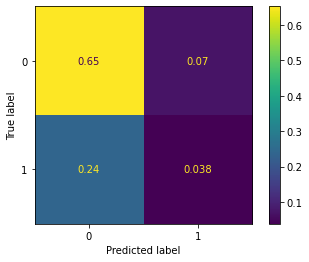

In [58]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(competition_test_set["related"], tfidf_svc_y_test, normalize="all")

#### BERT

In [33]:
bert_svc = SVC(C=SVM_C, kernel=SVM_KERNEL, degree=SVM_DEGREE, verbose=1)

In [ ]:
bert_svc.fit(bert_x_train, train_set["related"])

In [40]:
joblib.dump(bert_svc, "bert_svc.joblib")

['bert_svc.joblib']

In [41]:
bert_svc_y_test = bert_svc.predict(bert_x_test)

In [47]:
np.save("bert_svc_y_test.npy", bert_svc_y_test)

In [37]:
bert_svc.score(bert_x_test, competition_test_set["related"])

0.7949081178924172

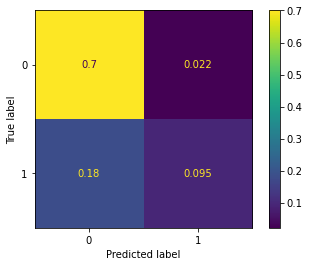

In [48]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(competition_test_set["related"], bert_svc_y_test, normalize="all")

### Deep Learning: GRU and BertClassifier

#### GRU Model

Training and evaluation code based on https://blog.floydhub.com/gru-with-pytorch/

In [ ]:
# Custom base GRU model (not used at the moment)
class GRU(nn.Module):
    def __init__(self, in_features, hidden_size, bias=True):
        super().__init__()
        self.in_features = in_features
        self.hidden_size = hidden_size
        self.fc_update = nn.Linear(in_features + hidden_size, 1, bias=bias)
        self.fc_reset = nn.Linear(in_features + hidden_size, 1, bias=bias)
        self.fc_inter = nn.Linear(in_features + hidden_size, hidden_size, bias=bias)

    def forward(self, x, h_prev):
        h_prev_x = torch.cat((h_prev, x))
        z = F.sigmoid(self.fc_update(h_prev_x))
        r = F.sigmoid(self.fc_reset(h_prev_x))
        h_tilde = F.tanh(self.fc_inter(torch.cat(r * h_prev, x)))
        return (1.0 - z) * h_prev + z * h_tilde


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

Training and evaluation code

In [ ]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 512
EPOCHS = 3


def train(train_loader, learn_rate=LEARNING_RATE, hidden_dim=256, epochs=EPOCHS):

    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2

    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of GRU model")
    epoch_times = []
    # Start training loop
    for epoch in range(1, epochs + 1):
        start_time = time.clock()
        h = model.init_hidden(BATCH_SIZE)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data

            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, epochs, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    smape = 0
    for i in range(len(outputs)):
        smape += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(smape*100))
    return outputs, targets, smape


#### TF-IDF

In [ ]:
tfidf_gru_model = GRU(tfidf_x_train.shape[1], 2)
train(tfidf_gru_model, EPOCHS, tfidf_x_train)
tfidf_x_test_dl = tfidf_gru_model(tfidf_x_test)

#### BERT

In [ ]:
bert_gru_model = GRU(bert_x_train.shape[1], 2)
train(tfidf_gru_model, EPOCHS, bert_x_train)
bert_x_test_dl = tfidf_gru_model(tfidf_x_test)

#### BERT Classifier

Using https://github.com/charles9n/bert-sklearn PyTorch implementation

In [59]:
bert_model = BertClassifier()
bert_model.fit(train_set["wholeArticle"], train_set["related"])

Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 44975, validation data size: 4997


Training  :   0%|          | 0/1406 [00:00<?, ?it/s]F:\Users\Max\anaconda3\envs\nlp-assignment\lib\site-packages\bert_sklearn\model\pytorch_pretrained\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Validating: 100%|██████████| 625/625 [00:43<00:00, 14.40it/s]

Epoch 1, Train loss: 0.0865, Val loss: 0.0187, Val accy: 99.40%



Validating: 100%|██████████| 625/625 [00:40<00:00, 15.46it/s]

Epoch 2, Train loss: 0.0109, Val loss: 0.0127, Val accy: 99.56%



Validating: 100%|██████████| 625/625 [00:39<00:00, 15.66it/s]

Epoch 3, Train loss: 0.0029, Val loss: 0.0077, Val accy: 99.78%


BertClassifier(do_lower_case=True, label_list=array([0, 1]))

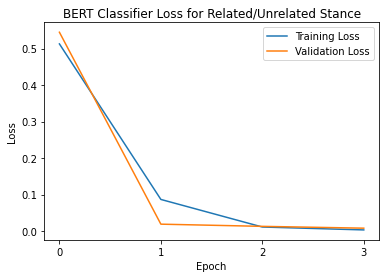

In [76]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("BERT Classifier Loss for Related/Unrelated Stance")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot([0, 1, 2, 3], [0.513, 0.0865, 0.0109, 0.00293], label="Training Loss")
plt.plot([0, 1, 2, 3], [0.545, 0.0187, 0.0127, 0.0077], label="Validation Loss")
plt.legend()
plt.show()

In [37]:
bert_model.score(competition_test_set["wholeArticle"], competition_test_set["related"])

Testing: 100%|██████████| 3177/3177 [02:14<00:00, 23.58it/s]


Loss: 0.0811, Accuracy: 97.96%


97.9616731594066

In [38]:
bert_competition_predictions = bert_model.predict(competition_test_set["wholeArticle"])

Predicting: 100%|██████████| 3177/3177 [02:16<00:00, 23.22it/s]


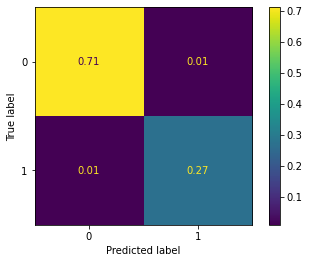

In [42]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(competition_test_set["related"], bert_competition_predictions, normalize="all")

In [67]:
def get_related(dataset):
    # Create new column for whether headlines are related or unrelated to bodies
    return dataset[dataset["Stance"] != "unrelated"]


train_set_related = get_related(train_set)
test_set_related = get_related(competition_test_set)

In [70]:
train_set_related["Stance"].value_counts(normalize=True)

discuss     0.663514
agree       0.273926
disagree    0.062561
Name: Stance, dtype: float64

In [72]:
bert_model_all = BertClassifier()
bert_model_all.fit(train_set_related["wholeArticle"], train_set_related["Stance"])

Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 12085, validation data size: 1342


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 7.19 GiB already allocated; 0 bytes free; 7.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF